# 1. EDA and Cleaning

In [97]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [98]:
# Read in Data
housing = pd.read_csv('datasets/train.csv')
housing_test = pd.read_csv('datasets/test.csv')

### Read through data dictionary, decide on which variables to use

In [99]:
# Remove spaces in col names b/c data dictionary col names do not include spaces
housing.columns = [n.replace(" ", "") for n in housing.columns]

# Save var names in txt file
# Create function to get variable names into list from txt file
# https://stackoverflow.com/questions/23372086/how-would-i-read-only-the-first-word-of-each-line-of-a-text-file
def get_var_name(txt_file):
    vars = []
    with open(txt_file, 'r') as f:
        for line in f:
            vars.append(line.split(None, 1)[0][:-1])
    return vars

init_vars = get_var_name('datasets/initial_vars.txt')
housing_init = housing[init_vars]

### Null values

In [100]:
# Check for NA values. 
# housing_init.isna().mean()
# Replace NAs with 0. They are not missing values, but 0 (i.e. basement bathroom is 0 not NA if there is no basement)
# https://www.geeksforgeeks.org/replace-nan-values-with-zeros-in-pandas-dataframe/
housing_init = housing_init.fillna(0)

### Variable Transformations

#### Add 'age' of home to be time since build or latest remodel. Assume data is from 2011

In [101]:
# Calculate age as 2011 - year of latest remodel or build
# housing_init['YearRemod/Add'].groupby(housing_init['YearRemod/Add']).count()
housing_init['Age'] = 2011 - housing_init['YearRemod/Add']
housing_init.drop(columns =['YearRemod/Add'], inplace= True)

In [102]:
# Ages range from 1-61 years, which makes sense 
housing_init['Age'].describe()

count    2051.000000
mean       26.809849
std        21.036250
min         1.000000
25%         7.000000
50%        18.000000
75%        46.500000
max        61.000000
Name: Age, dtype: float64

#### Add 'TotalBaths' as new variable, adding up basement full bathrooms, basement half bathrooms, full bathrooms above grade, and half bathrooms above grade. 

In [103]:
# Create new column in dataset for total number of bathrooms
housing_init['TotalBaths'] = housing_init['BsmtFullBath'] + 0.5*housing_init['BsmtHalfBath'] + housing_init['FullBath'] + 0.5*housing_init['HalfBath']
housing_init['TotalBaths'].describe()
housing_init.drop(columns =['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace= True)

#### Add 'OutdoorSF' as outdoor square feet, which represents the sum of wood deck, open porch, enclosed porch, 3 screen porch and screen porch square feet. 

In [104]:
# Add new column for outdoor square footage
housing_init['OutdoorSF'] = housing_init['WoodDeckSF'] + housing_init['OpenPorchSF'] + housing_init['EnclosedPorch'] + housing_init['3SsnPorch'] + housing_init['ScreenPorch'] 
housing_init['OutdoorSF'].describe()
housing_init.drop(columns =['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], inplace= True)

#### Convert month sold into calendar year quarter (Q1 for Jan-Mar, etc.)

In [105]:
# https://www.nar.realtor/blogs/economists-outlook/seasonality-in-the-housing-market
housing_init['MoSold'].describe()

# Cast quarter to new column from month 
housing_init['Quarter'] = np.nan
q = []
for month in housing_init['MoSold']:
    if month < 4:
        q.append('Q1')
    elif month < 7:
        q.append('Q2')
    elif month < 10:
        q.append('Q3')
    else:
        q.append('Q4')
housing_init['Quarter'] = q

housing_init.drop(columns =['MoSold'], inplace=True)
# housing_init['Quarter'].groupby(housing_init['Quarter']).count()

#### Convert year to binary variable 'GFC', before and after 2008 (Great Financial Crisis) which negatively impacted real estate prices. 

In [106]:
housing_init['SalePrice'].groupby(housing_init['YrSold']).mean()

# Cast yr sold as before/after GFC
housing_init['GFC'] = np.nan
year = []
for yr in housing_init['YrSold']:
    if yr > 2009:
        year.append('0')
    else:
        year.append('1')
housing_init['GFC'] = year

housing_init.drop(columns =['YrSold'], inplace=True)
# housing_init['GFC'].groupby(housing_init['GFC']).count()

### Variable Types

In [107]:
# housing_init.info()
# Break out dummy vars. Convert variables to categorical (do this after TTS) 
housing_init_dummy = housing_init.drop(columns = ['TotalBsmtSF', 'GrLivArea', 'MiscVal', 'PoolArea', 'SalePrice', 'Age', 'OutdoorSF', 'TotRmsAbvGrd', 'GarageCars', 'Fireplaces', 'TotalBaths'])
# Break out numeric variables. Ensure in right variable type (float/int)
housing_init_num = housing_init[['TotalBsmtSF', 'GrLivArea', 'MiscVal', 'PoolArea', 'Age', 'OutdoorSF', 'TotRmsAbvGrd', 'GarageCars', 'Fireplaces', 'TotalBaths']]
# housing_init_num

In [108]:
# Create combined new data set for X variables
# https://pandas.pydata.org/docs/reference/api/pandas.concat.html
housing_xvars = pd.concat([housing_init_dummy, housing_init_num], axis=1)
housing_xvars.head()
# housing_xvars.info()

,MSSubClass,MSZoning,Neighborhood,OverallQual,OverallCond,HeatingQC,CentralAir,Condition1,Quarter,GFC,TotalBsmtSF,GrLivArea,MiscVal,PoolArea,Age,OutdoorSF,TotRmsAbvGrd,GarageCars,Fireplaces,TotalBaths
0,60,RL,Sawyer,6,8,Ex,Y,RRAe,Q1,0,725.0,1479,0,0,6,44,6,2.0,0,2.5
1,60,RL,SawyerW,7,5,Ex,Y,Norm,Q2,1,913.0,2122,0,0,14,74,8,2.0,1,3.5
2,20,RL,NAmes,5,7,TA,Y,Norm,Q1,0,1057.0,1057,0,0,4,52,5,1.0,0,2.0
3,60,RL,Timber,5,5,Gd,Y,Norm,Q2,0,384.0,1444,0,0,4,100,7,2.0,0,2.5
4,50,RL,SawyerW,6,8,TA,Y,Norm,Q1,0,676.0,1445,0,0,18,59,6,2.0,0,2.0


#### Data Visualization

##### Histogram shows sale price is right skewed. 

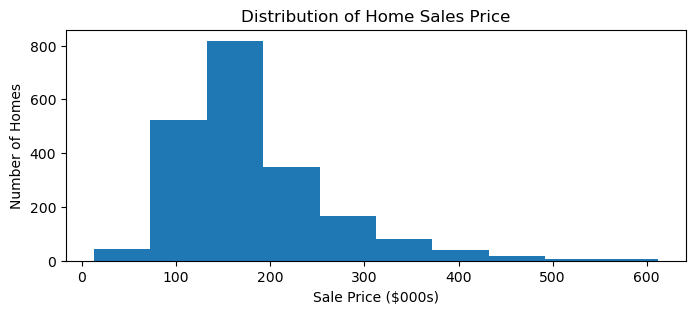

In [109]:
# Sale Price Histogram
plt.figure(figsize=(8,3))
plt.hist(housing_init['SalePrice']/1000)
plt.xlabel('Sale Price ($000s)')
plt.ylabel('Number of Homes')
plt.title('Distribution of Home Sales Price');

##### Histogram shows total rooms is slightly right skewed. 

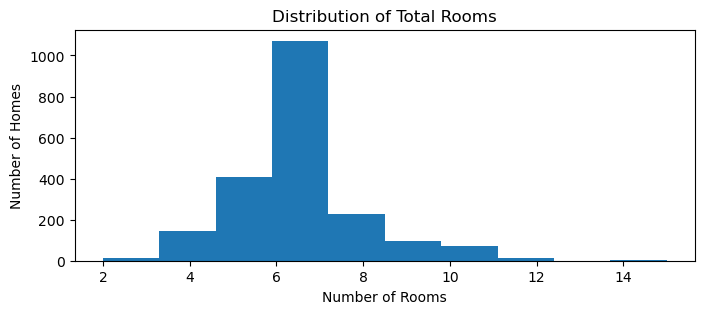

In [110]:
# Sale Price Histogram
plt.figure(figsize=(8,3))
plt.hist(housing_init['TotRmsAbvGrd'])
plt.xlabel('Number of Rooms')
plt.ylabel('Number of Homes')
plt.title('Distribution of Total Rooms');

##### Bar chart of houses by neighborhood

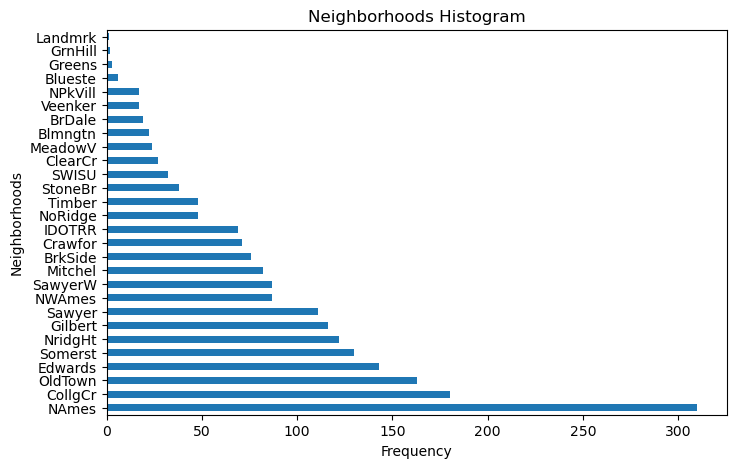

In [111]:
# https://saturncloud.io/blog/creating-a-histogram-of-a-categorical-variable-with-matplotlib/#:~:text=Matplotlib%20is%20a%20powerful%20Python,the%20ability%20to%20create%20histograms.
plt.figure(figsize=(8,5))
housing_init['Neighborhood'].value_counts().plot(kind='barh')
plt.title('Neighborhoods Histogram')
plt.xlabel('Frequency')
plt.ylabel('Neighborhoods')
plt.show()

##### Boxplot of rooms shows a positive relationship to sale price. 

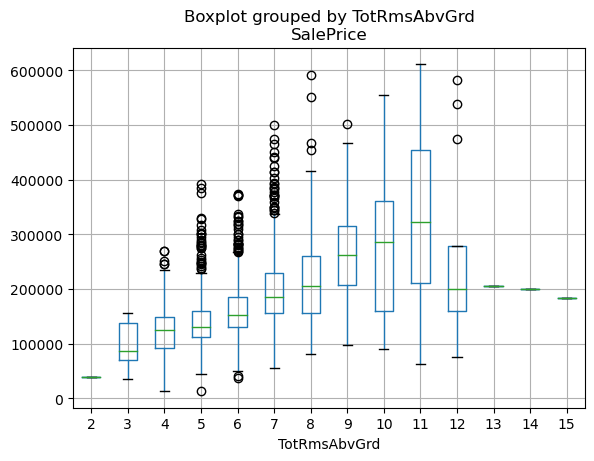

In [112]:
housing_init.boxplot(column = 'SalePrice', by = 'TotRmsAbvGrd');

##### Boxplot by Neighborhood

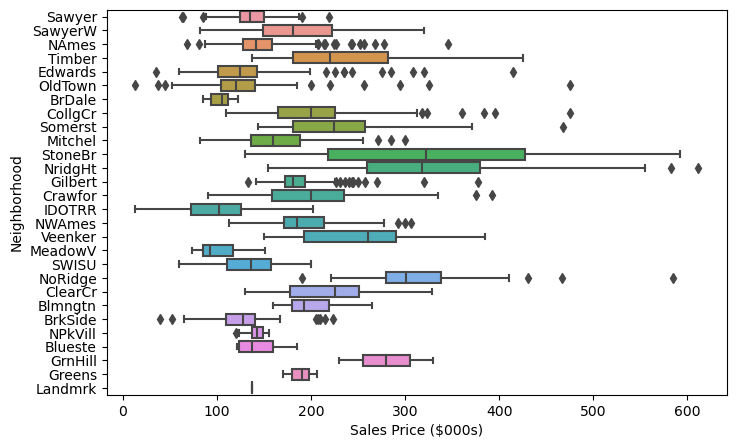

In [113]:
plt.figure(figsize=(8,5))
sns.boxplot(x = housing_init['SalePrice']/1000, y = housing_init['Neighborhood'])
plt.xlabel('Sales Price ($000s)')
plt.savefig('boxplot_neighborhood.png', dpi=192);
# round(housing_init['SalePrice'].groupby(housing_init['Neighborhood']).mean().sort_values(), 1)

##### Bar chart of average quality per home in a neighborhood

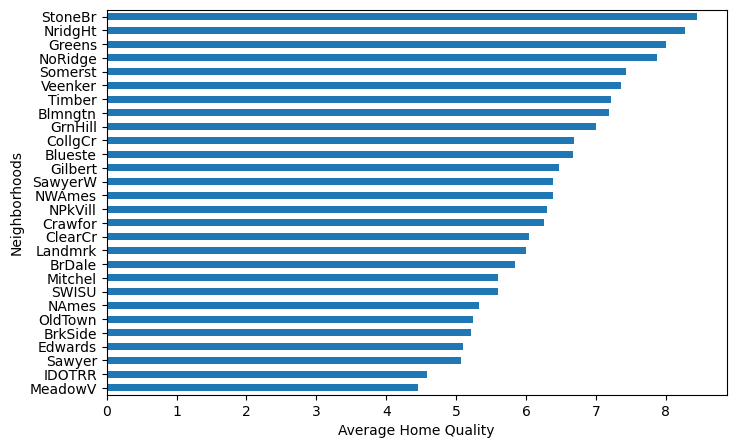

In [114]:
plt.figure(figsize=(8,5))
housing_init['OverallQual'].groupby(housing_init['Neighborhood']).mean().sort_values().plot(kind='barh')
plt.xlabel('Average Home Quality')
plt.ylabel('Neighborhoods')
plt.show();
# housing_init['OverallQual'].groupby(housing_init['Neighborhood']).mean().sort_values()

##### Bar chart of average selling price per home in a neighborhood

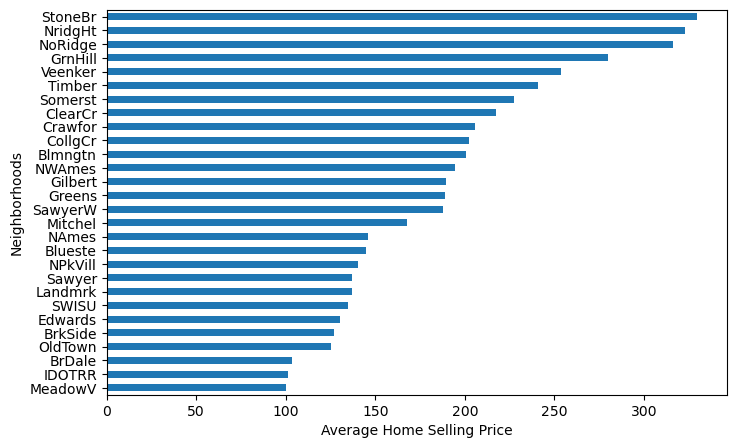

In [115]:
plt.figure(figsize=(8,5))
(housing_init['SalePrice']/1000).groupby(housing_init['Neighborhood']).mean().sort_values().plot(kind='barh')
plt.xlabel('Average Home Selling Price')
plt.ylabel('Neighborhoods')
plt.show();
# (housing_init['SalePrice']/1000).groupby(housing_init['Neighborhood']).mean().sort_values()

##### Bar chart of average age of home in a neighborhood

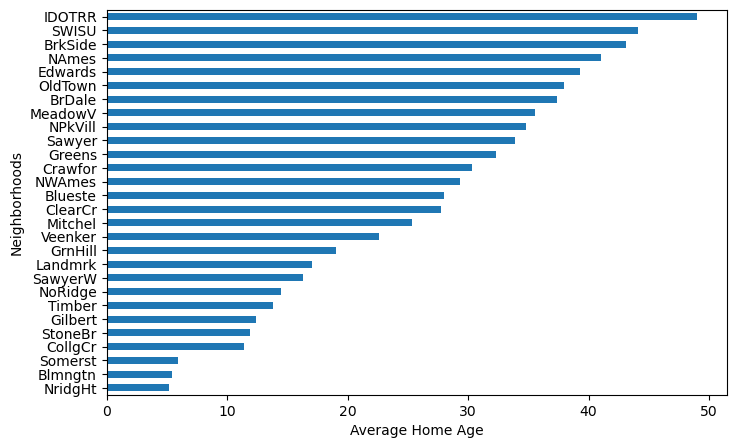

In [116]:
plt.figure(figsize=(8,5))
housing_init['Age'].groupby(housing_init['Neighborhood']).mean().sort_values().plot(kind='barh')
plt.xlabel('Average Home Age')
plt.ylabel('Neighborhoods')
plt.show();
# housing_init['Age'].groupby(housing_init['Neighborhood']).mean().sort_values()

##### Bar chart of average sq footage per home in a neighborhood

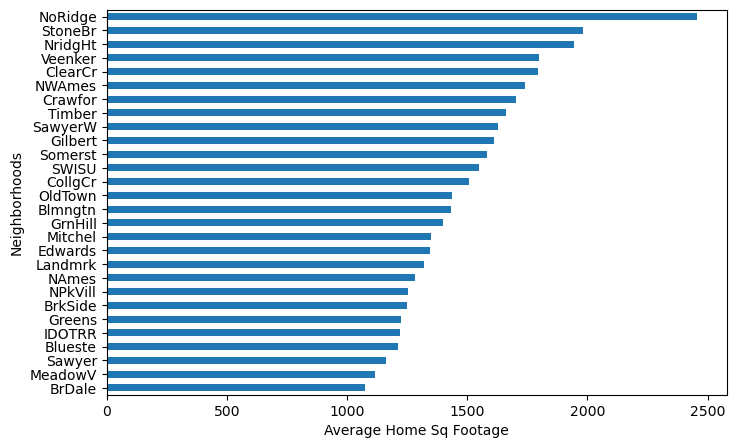

In [117]:
plt.figure(figsize=(8,5))
housing_init['GrLivArea'].groupby(housing_init['Neighborhood']).mean().sort_values().plot(kind='barh')
plt.xlabel('Average Home Sq Footage')
plt.ylabel('Neighborhoods')
plt.show();
# round(housing_init['GrLivArea'].groupby(housing_init['Neighborhood']).mean().sort_values(), 1)

##### Boxplot shows that overall quality is positively related to sales price.

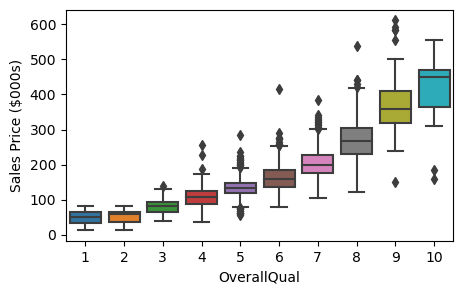

In [118]:
plt.figure(figsize=(5,3))
sns.boxplot(y = housing_init['SalePrice']/1000, x = housing_init['OverallQual'])
plt.ylabel('Sales Price ($000s)');

##### Sales price is most closely correlated to overall quality (0.8), living area size (0.7), number of garages (0.65), total baths (0.63) and age (-0.55). 

C:\Users\13478\AppData\Local\Temp\ipykernel_22876\4065974880.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(housing_init.corr(), cmap = 'coolwarm', vmin = -1, annot = True);


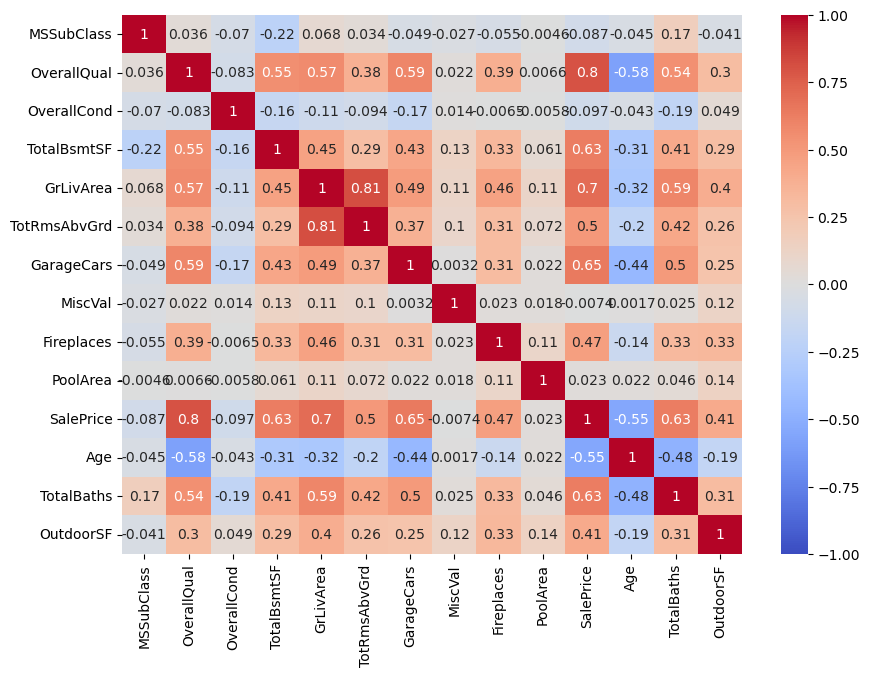

In [119]:
plt.figure(figsize=(10,7))
sns.heatmap(housing_init.corr(), cmap = 'coolwarm', vmin = -1, annot = True);

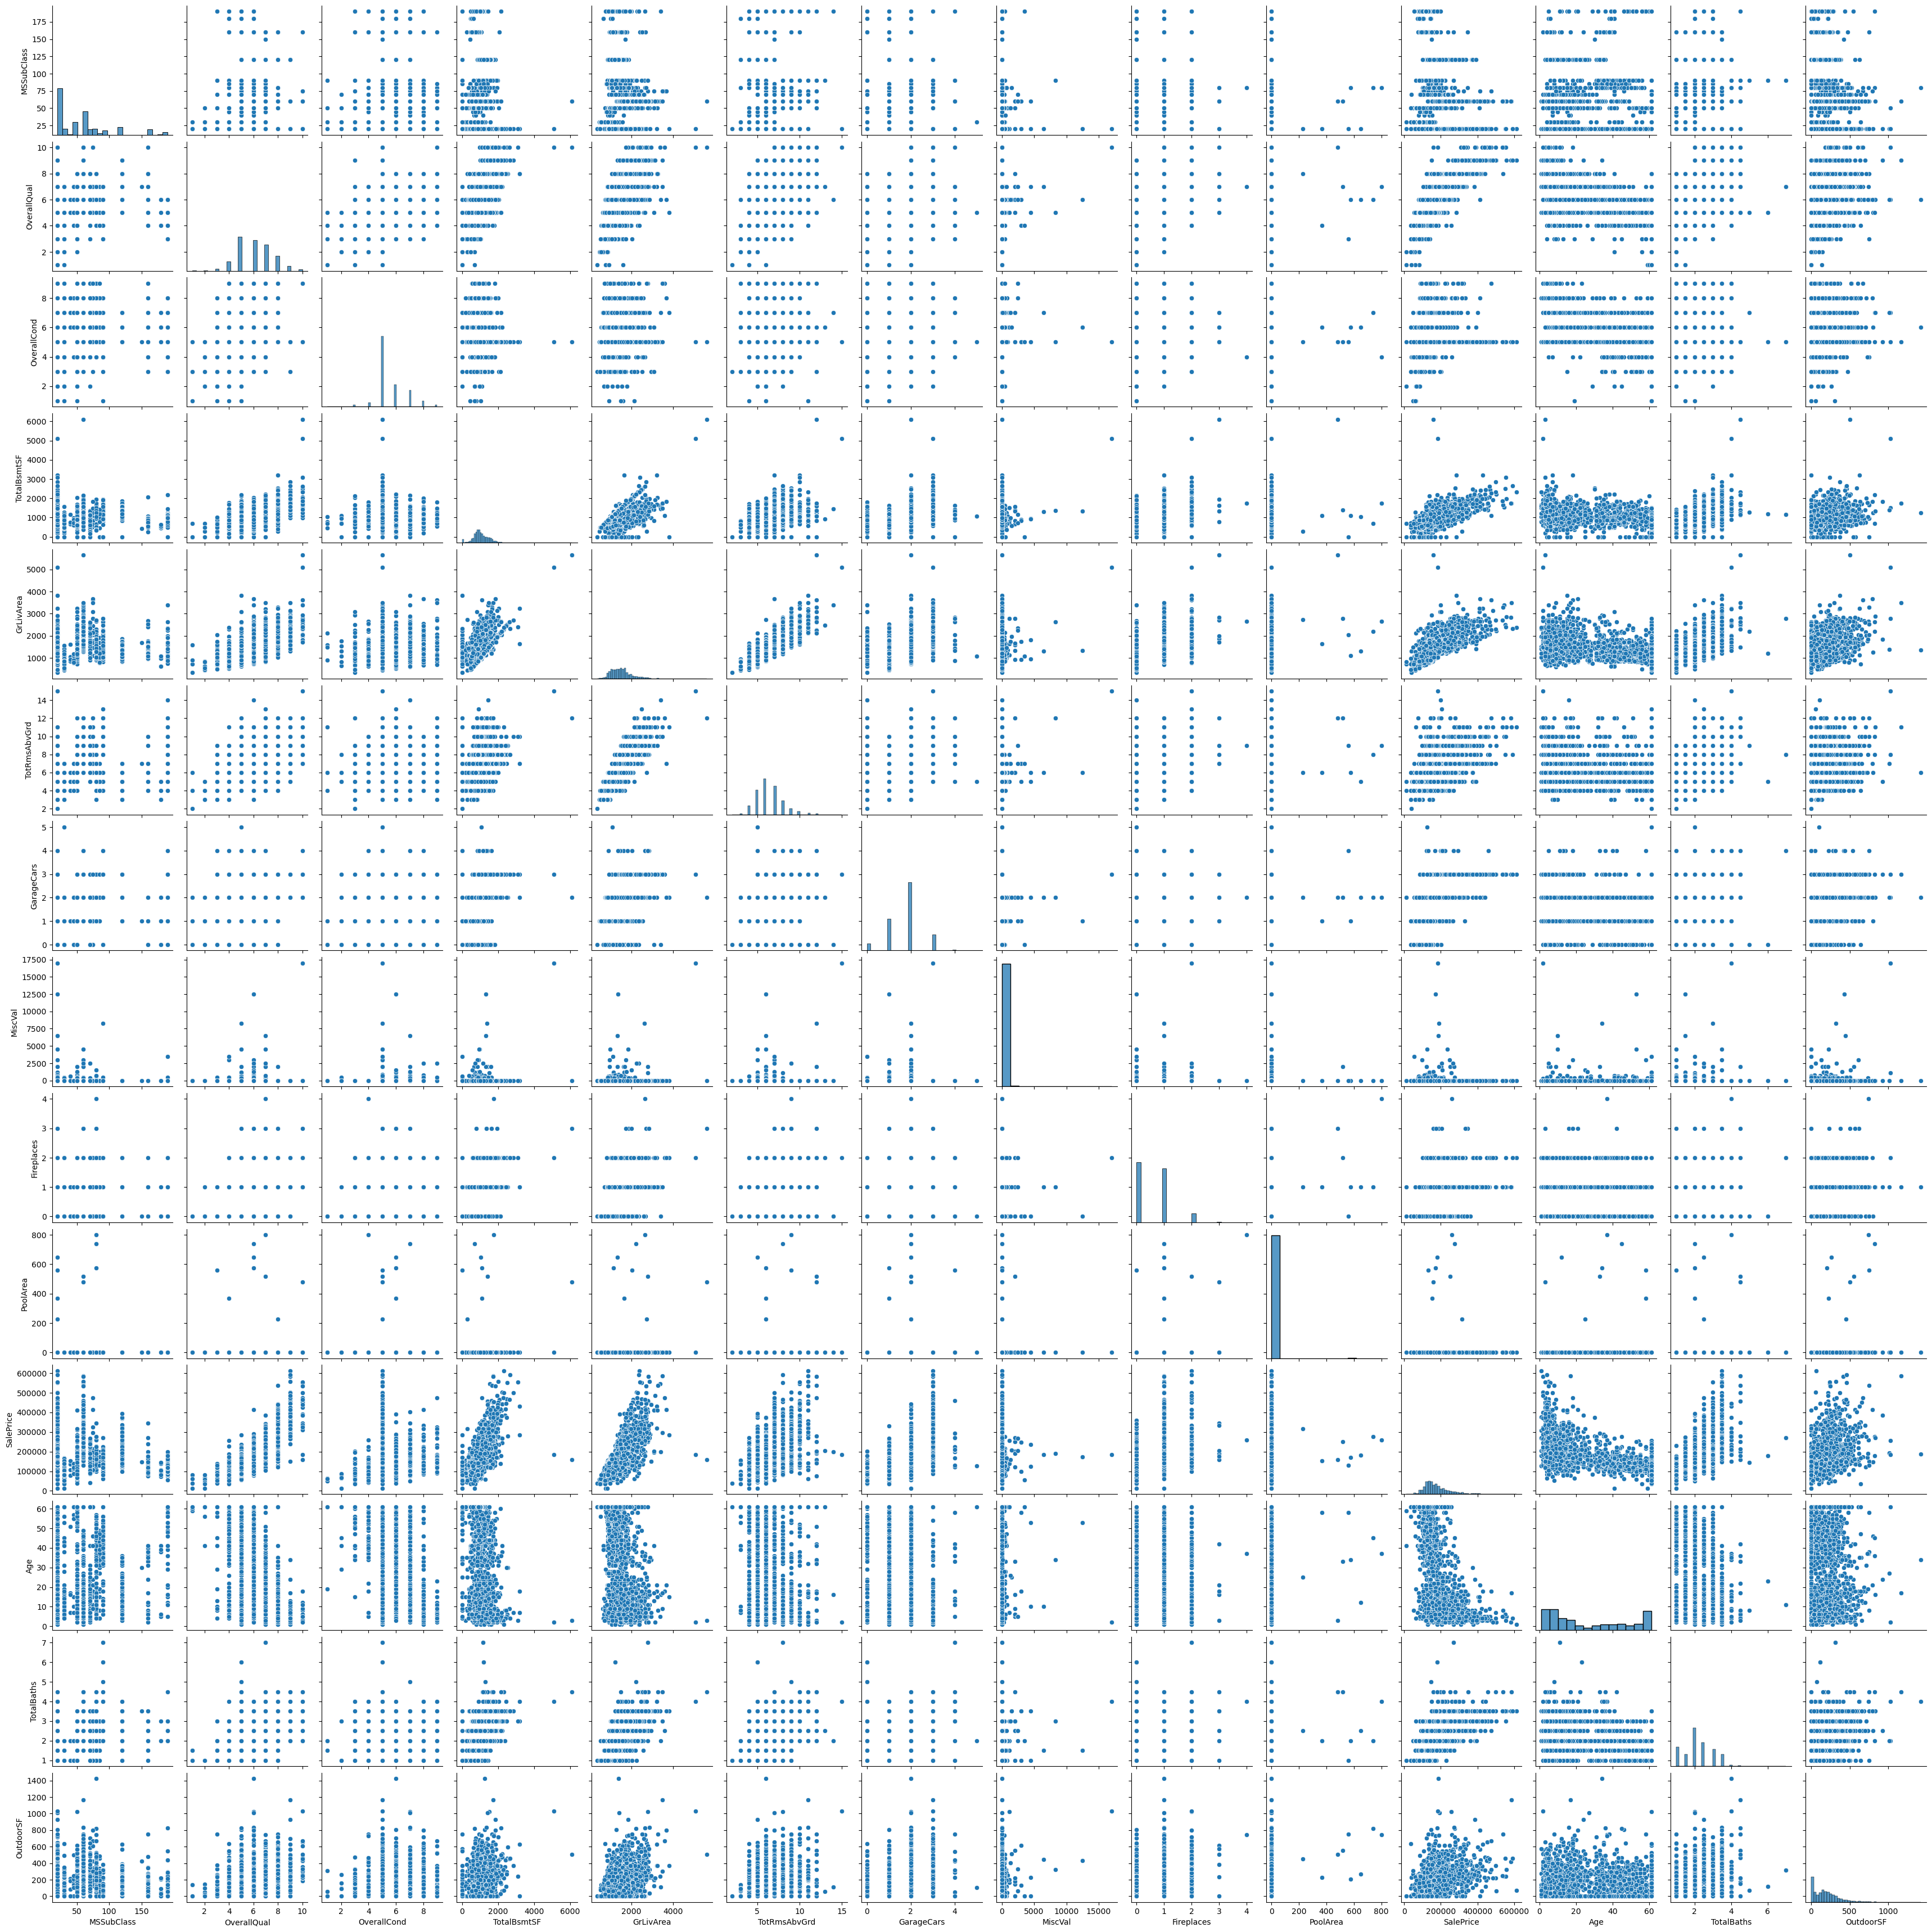

In [120]:
sns.pairplot(housing_init);

# Preproccesing 

In [121]:
# Convert variables to categorical with OHE
oh = OneHotEncoder(sparse = False, drop = 'first')
housing_init_dummy_oh = oh.fit_transform(housing_init_dummy)
housing_xvars_oh = pd.concat([pd.DataFrame(housing_init_dummy_oh, columns = oh.get_feature_names_out()), housing_init_num], axis=1)

C:\Users\13478\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [122]:
# Define X and y variables
X = housing_xvars_oh
y = housing_init['SalePrice']

# TTS
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 95)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1538, 92) (1538,)
(513, 92) (513,)


# Modeling

In [123]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))
preds = lr.predict(X)
# preds.shape

0.8873364495160501
0.877606905706273


##### Baseline model has an R-squared of 0, compared to 0.87 for the linear regression model.

In [124]:
# Baseline model
base_preds = [y_train.mean()]*len(y_test)
r2_score(y_test, base_preds)

-0.000935453726160107

### Convert test data in same way as training data

In [125]:
housing_test0 = pd.read_csv('datasets/test-Copy1.csv')
housing_test0.columns = [n.replace(" ", "") for n in housing_test0.columns]

init_vars1 = get_var_name('datasets/initial_vars-Copy1.txt')
housing_test1 = housing_test0[init_vars1]

housing_test1 = housing_test1.fillna(0)

housing_test1['Age'] = 2011 - housing_test1['YearRemod/Add']
housing_test1.drop(columns =['YearRemod/Add'], inplace= True)

housing_test1['TotalBaths'] = housing_test1['BsmtFullBath'] + 0.5*housing_test1['BsmtHalfBath'] + housing_test1['FullBath'] + 0.5*housing_test1['HalfBath']
housing_test1.drop(columns =['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace= True)

housing_test1['OutdoorSF'] = housing_test1['WoodDeckSF'] + housing_test1['OpenPorchSF'] + housing_test1['EnclosedPorch'] + housing_test1['3SsnPorch'] + housing_test1['ScreenPorch'] 
housing_test1.drop(columns =['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], inplace= True)

housing_test1['Quarter'] = np.nan
q = []
for month in housing_test1['MoSold']:
    if month < 4:
        q.append('Q1')
    elif month < 7:
        q.append('Q2')
    elif month < 10:
        q.append('Q3')
    else:
        q.append('Q4')
housing_test1['Quarter'] = q
housing_test1.drop(columns =['MoSold'], inplace=True)

housing_test1['GFC'] = np.nan
year = []
for yr in housing_test1['YrSold']:
    if yr > 2009:
        year.append('0')
    else:
        year.append('1')
housing_test1['GFC'] = year
housing_test1.drop(columns =['YrSold'], inplace=True)

housing_test1_dummy = housing_test1.drop(columns = ['TotalBsmtSF', 'GrLivArea', 'MiscVal', 'PoolArea', 'Age', 'OutdoorSF', 'TotRmsAbvGrd', 'GarageCars', 'Fireplaces', 'TotalBaths'])
housing_test1_num = housing_test1[['TotalBsmtSF', 'GrLivArea', 'MiscVal', 'PoolArea', 'Age', 'OutdoorSF', 'TotRmsAbvGrd', 'GarageCars', 'Fireplaces', 'TotalBaths']]
oh = OneHotEncoder(sparse = False, drop = 'first')
housing_test1_dummy_oh = oh.fit_transform(housing_test1_dummy)
housing_xvars_test1_oh = pd.concat([pd.DataFrame(housing_test1_dummy_oh, columns = oh.get_feature_names_out()), housing_test1_num], axis=1)

C:\Users\13478\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Run model on testing data

In [126]:
# Need same columns present in test data and train data. 
# Identify missing columns bw test and training data then add as 0s where appropriate
# housing_xvars_test1_oh
miss_cols = housing_xvars_oh.columns.difference(housing_xvars_test1_oh.columns)

# Add missing columns to test data, fill with 0s
housing_xvars_test1_oh[miss_cols] = 0
# housing_xvars_oh.columns

# Sort columns in test data so in same order as training data
# housing_xvars_test1_oh_sorted = pd.DataFrame(housing_xvars_test1_oh, columns = housing_xvars_oh.columns)
housing_xvars_test1_oh = housing_xvars_test1_oh[housing_xvars_oh.columns]

In [127]:
# Get predictions on test data 
test_preds = lr.predict(housing_xvars_test1_oh)

# Fit test data with model
housing_test0['SalePrice'] = test_preds
# housing_test0

In [128]:
# Save excel for submission
submission1 = housing_test0[['Id', 'SalePrice']]
submission1.set_index('Id', inplace = True)
submission1.to_csv('submission1.csv')
# submission1

# Interpretation

In [129]:
set(zip(housing_xvars_oh.columns, np.around(lr.coef_, 2)))

{('Age', -147.51),
 ('CentralAir_Y', 1607.56),
 ('Condition1_Feedr', -6937.84),
 ('Condition1_Norm', 6349.15),
 ('Condition1_PosA', 30455.02),
 ('Condition1_PosN', 13186.21),
 ('Condition1_RRAe', -9637.17),
 ('Condition1_RRAn', 8397.94),
 ('Condition1_RRNe', -44319.8),
 ('Condition1_RRNn', -10347.03),
 ('Fireplaces', 8152.73),
 ('GFC_1', -2231.47),
 ('GarageCars', 8411.58),
 ('GrLivArea', 37.97),
 ('HeatingQC_Fa', -7283.71),
 ('HeatingQC_Gd', -3528.49),
 ('HeatingQC_Po', -24521.27),
 ('HeatingQC_TA', -7320.48),
 ('MSSubClass_120', -34766.58),
 ('MSSubClass_150', -72179.41),
 ('MSSubClass_160', -43393.96),
 ('MSSubClass_180', -22640.71),
 ('MSSubClass_190', -15320.27),
 ('MSSubClass_30', -7529.86),
 ('MSSubClass_40', -25933.57),
 ('MSSubClass_45', -4199.9),
 ('MSSubClass_50', -9614.48),
 ('MSSubClass_60', -11748.16),
 ('MSSubClass_70', -15616.01),
 ('MSSubClass_75', -6702.45),
 ('MSSubClass_80', -9589.5),
 ('MSSubClass_85', 643.12),
 ('MSSubClass_90', -22080.36),
 ('MSZoning_C (all)', 5

In [130]:
import statsmodels.api as sm

X = housing_xvars_oh
X = sm.add_constant(X)
y = housing_init['SalePrice']
ols = sm.OLS(y, X).fit()
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     168.1
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:45:36   Log-Likelihood:                -23804.
No. Observations:                2051   AIC:                         4.779e+04
Df Residuals:                    1958   BIC:                         4.832e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.183e+04   2.75e+04     -0.429      0.668   -6.59e+04    4.22e+04
MSSubClass_30        -9232.5466   3717.252     -2.484      0.013   -1.65e+04   -1942.360
MSSubClass_40         -1.66e+04    1.4e+04     -1.185      0.236   -4.41e+04    1.09e+04
MSSubClass_45        -2074.8997   8840.779     -0.235      0.814   -1.94e+04    1.53e+04
MSSubClass_50        -9671.5346   3027.831     -3.194      0.001   -1.56e+04   -3733.424
MSSubClass_60         -1.02e+04   2655.844     -3.842      0.000   -1.54e+04   -4995.557
MSSubClass_70        -1.732e+04   4146.224     -4.177      0.000   -2.54e+04   -9186.979
MSSubClass_75        -1.144e+04   7890.964     -1.450      0.147   -2.69e+04    4037.333
MSSubClass_80        -6356.2790   3354.580     -1.895      0.058   -1.29e+04     222.643
MSSubClass_85         1602.1774   5404.223      0.296      0.767   -8996.456    1.22e+04
MSSubClass_90        -2.261e+04   3957.329     -5.713      0.000   -3.04e+04   -1.48e+04
MSSubClass_120       -3.691e+04   3476.635    -10.618      0.000   -4.37e+04   -3.01e+04
MSSubClass_150       -6.644e+04    2.8e+04     -2.369      0.018   -1.21e+05   -1.14e+04
MSSubClass_160        -4.68e+04   4899.753     -9.552      0.000   -5.64e+04   -3.72e+04
MSSubClass_180       -2.418e+04   9897.415     -2.443      0.015   -4.36e+04   -4772.948
MSSubClass_190       -1.859e+04   4768.457     -3.899      0.000   -2.79e+04   -9240.193
MSZoning_C (all)      5.335e+04   3.12e+04      1.713      0.087   -7736.736    1.14e+05
MSZoning_FV           6.541e+04   3.07e+04      2.134      0.033    5289.258    1.26e+05
MSZoning_I (all)      5.477e+04   4.21e+04      1.301      0.194   -2.78e+04    1.37e+05
MSZoning_RH           6.354e+04    3.1e+04      2.048      0.041    2688.907    1.24e+05
MSZoning_RL           5.453e+04      3e+04      1.817      0.069   -4332.551    1.13e+05
MSZoning_RM           6.187e+04   3.02e+04      2.046      0.041    2574.108    1.21e+05
Neighborhood_Blueste -1.857e+04   1.36e+04     -1.366      0.172   -4.52e+04    8094.402
Neighborhood_BrDale  -1.033e+04   1.06e+04     -0.975      0.330   -3.11e+04    1.05e+04
Neighborhood_BrkSide -3.381e+04   8380.541     -4.034      0.000   -5.02e+04   -1.74e+04
Neighborhood_ClearCr -2620.1074   8560.514     -0.306      0.760   -1.94e+04    1.42e+04
Neighborhood_CollgCr  -1.85e+04   6841.416     -2.704      0.007   -3.19e+04   -5084.316
Neighborhood_Crawfor -2825.9047   7537.066     -0.375      0.708   -1.76e+04     1.2e+04
Neighborhood_Edwards -3.439e+04   7278.437     -4.724      0.000   -4.87e+04   -2.01e+04
Neighborhood_Gilbert -2.468e+04   7134.926     -3.459      0.001   -3.87e+04   -1.07e+04
Neighborhood_Greens  -6973.2621   1.71e+04     -0.408      0.684   -4.05e+04    2.66e+04
Neighborhood_GrnHill  1.144e+05   2.05e+04      5.581    